In [1]:
import os #allows us to access the dataset we will load in the dataset
import pandas as pd #the data manipulation library we will be using
import numpy as np #allows us to do numerical computing
import matplotlib.pyplot as plt #allow us to visualize our data
import seaborn as sns #allows for more advanced visualizations

In [2]:
# load in kaggle dataset through command line
# ! an exclamation point means you are running a command on notebook
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip

# the above command will download the dataset called from "username/datasetName"
# and will unzip those files in collab for us to use

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 87%|███████████████████████████████████▌     | 129M/149M [00:00<00:00, 190MB/s]
100%|█████████████████████████████████████████| 149M/149M [00:00<00:00, 196MB/s]


In [3]:
# create a dataframe with designated paths to each type of brain tumor
# gets the metadata from the training/testing path to store in dataframe
def get_class_paths(path): # path is the directory for the dataset
  classes = []
  class_paths = []

  # Iterate through directories in the training path
  for label in os.listdir(path):
    label_path = os.path.join(path, label)

    # Check if it's a directory
    if os.path.isdir(label_path):
      # Iterate through images in the label directory
      for image in os.listdir(label_path):
        image_path = os.path.join(label_path, image)

        # Add class and path to respective lists
        classes.append(label)
        class_paths.append(image_path)

  # Create a DataFrame with the collected data
  df = pd.DataFrame({
      'Class Path': class_paths,
      'Class': classes
  })
  return df

In [4]:
# within collab path is always "/content/.../..."
train_df = get_class_paths("/kaggle/working/Training")

In [5]:
train_df

,Class Path,Class
0,/kaggle/working/Training/notumor/Tr-no_1455.jpg,notumor
1,/kaggle/working/Training/notumor/Tr-no_0771.jpg,notumor
2,/kaggle/working/Training/notumor/Tr-no_1387.jpg,notumor
3,/kaggle/working/Training/notumor/Tr-no_0691.jpg,notumor
4,/kaggle/working/Training/notumor/Tr-no_0503.jpg,notumor
...,...,...
5707,/kaggle/working/Training/meningioma/Tr-me_1087...,meningioma
5708,/kaggle/working/Training/meningioma/Tr-me_1119...,meningioma
5709,/kaggle/working/Training/meningioma/Tr-me_1275...,meningioma
5710,/kaggle/working/Training/meningioma/Tr-me_0162...,meningioma


In [6]:
test_df = get_class_paths("/kaggle/working/Testing")

In [7]:
test_df

,Class Path,Class
0,/kaggle/working/Testing/notumor/Te-no_0154.jpg,notumor
1,/kaggle/working/Testing/notumor/Te-no_0198.jpg,notumor
2,/kaggle/working/Testing/notumor/Te-no_0123.jpg,notumor
3,/kaggle/working/Testing/notumor/Te-no_0375.jpg,notumor
4,/kaggle/working/Testing/notumor/Te-no_0169.jpg,notumor
...,...,...
1306,/kaggle/working/Testing/meningioma/Te-me_0166.jpg,meningioma
1307,/kaggle/working/Testing/meningioma/Te-me_0218.jpg,meningioma
1308,/kaggle/working/Testing/meningioma/Te-me_0289.jpg,meningioma
1309,/kaggle/working/Testing/meningioma/Te-me_0138.jpg,meningioma


In [8]:
# Now split data into 3: Training data, Testing data, Validation Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix # evaluate performance of the model
import tensorflow as tf
from tensorflow.keras.models import Sequential # allows us to build a model layer by layer
from tensorflow.keras.layers import Dense, Dropout, Flatten #layers, optimizers, and metrics used to train the model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
# split testing data set into testing and validation
# necessary for tuning and to preventing overfitting
valid_df, test_df = train_test_split(test_df, train_size=0.5, stratify=test_df["Class"])
''' train_test_split(
      datasetBeingSplit,
      train_size=0.5 => this defines the size of each split 0.5 means it will split equally in half
      stratify=test_df => this is telling the program to make sure that each split is
                  proportionally the same in each class in comparison to the other split
                  ex. if valid_df has 4 no tumors then test_df would have roughly 4 no tumors
                  *the ratios would balance out in each

    )
    '''

' train_test_split(\n      datasetBeingSplit,\n      train_size=0.5 => this defines the size of each split 0.5 means it will split equally in half\n      stratify=test_df => this is telling the program to make sure that each split is\n                  proportionally the same in each class in comparison to the other split\n                  ex. if valid_df has 4 no tumors then test_df would have roughly 4 no tumors\n                  *the ratios would balance out in each\n\n    )\n    '

In [10]:
valid_df

,Class Path,Class
907,/kaggle/working/Testing/glioma/Te-gl_0142.jpg,glioma
1190,/kaggle/working/Testing/meningioma/Te-me_0096.jpg,meningioma
959,/kaggle/working/Testing/glioma/Te-gl_0269.jpg,glioma
77,/kaggle/working/Testing/notumor/Te-no_0090.jpg,notumor
621,/kaggle/working/Testing/pituitary/Te-pi_0210.jpg,pituitary
...,...,...
944,/kaggle/working/Testing/glioma/Te-gl_0231.jpg,glioma
1182,/kaggle/working/Testing/meningioma/Te-me_0285.jpg,meningioma
1289,/kaggle/working/Testing/meningioma/Te-me_0243.jpg,meningioma
1058,/kaggle/working/Testing/meningioma/Te-me_0133.jpg,meningioma


In [11]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers

In [12]:
# Batch size is the number of images the model will process at once
batch_size = 16
img_size = (224, 224)
#both of the above reduce the memory usage needed

# rescale the pixel values and adjusting their brightness to help model be more robust and generalized to more data
image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))

test_gen = ImageDataGenerator(rescale=1/255)

# Create Training Data Flow
train_gen = image_generator.flow_from_dataframe(train_df,
                                                x_col="Class Path",
                                                y_col="Class",
                                                batch_size=batch_size,
                                                target_size=img_size
                                                )
# Create Validation Data Flow
valid_gen = image_generator.flow_from_dataframe(valid_df,
                                                x_col="Class Path",
                                                y_col="Class",
                                                batch_size=batch_size,
                                                target_size=img_size
                                                )

# Create Testing Data Flow
test_gen = test_gen.flow_from_dataframe(test_df,
                                        x_col="Class Path",
                                        y_col="Class",
                                        batch_size=16,
                                        target_size=img_size,
                                        shuffle=False #want order of the data to remain consistent
                                        )

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [13]:
# Create a Sequential model
cnn_model = Sequential()

# Convolutional layers
# Create 4 Convolutional Blocks
# each block has a different number of convolutional filters
# Filters extract features like edges, shapes, textures, etc.
cnn_model.add(Conv2D(512, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # focuses the model on most important features and reduces the # of parameters

# more complex patterns based on first block of filters
cnn_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128,(3,3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten the output for fully connected layers
cnn_model.add(Flatten())

# Fully connected layers
cnn_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(Dropout(0.35))

cnn_model.add(Dense(4, activation='softmax'))
# Output layer with 4 neurons for the 4 classes

# Compile the model
cnn_model.compile(Adamax(learning_rate = 0.001),
                  loss='categorical_crossentropy',
                  metrics= ['accuracy', Precision(), Recall()])

# Display the model summary
cnn_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 512)  │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 512)  │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 512)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 256)  │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,245,892 (12.38 MB)

 Trainable params: 3,244,868 (12.38 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [14]:
#Train model
history = cnn_model.fit(train_gen, epochs=18, validation_data=valid_gen)

Epoch 1/18


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731633564.492478      77 service.cc:145] XLA service 0x7dd7e8010f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731633564.492530      77 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731633564.492535      77 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1731633594.504386      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


357/357 ━━━━━━━━━━━━━━━━━━━━ 136s 289ms/step - accuracy: 0.5292 - loss: 4.4551 - precision: 0.6427 - recall: 0.3588 - val_accuracy: 0.7160 - val_loss: 2.6084 - val_precision: 0.9783 - val_recall: 0.0687
Epoch 2/18
357/357 ━━━━━━━━━━━━━━━━━━━━ 95s 265ms/step - accuracy: 0.8006 - loss: 1.8564 - precision: 0.8298 - recall: 0.7561 - val_accuracy: 0.8137 - val_loss: 1.3719 - val_precision: 0.8510 - val_recall: 0.7588
Epoch 3/18
357/357 ━━━━━━━━━━━━━━━━━━━━ 95s 266ms/step - accuracy: 0.8624 - loss: 1.1770 - precision: 0.8775 - recall: 0.8455 - val_accuracy: 0.8046 - val_loss: 1.0356 - val_precision: 0.8441 - val_recall: 0.7771
Epoch 4/18
357/357 ━━━━━━━━━━━━━━━━━━━━ 95s 266ms/step - accuracy: 0.8836 - loss: 0.8298 - precision: 0.8950 - recall: 0.8730 - val_accuracy: 0.8519 - val_loss: 0.7385 - val_precision: 0.8724 - val_recall: 0.8351
Epoch 5/18
357/357 ━━━━━━━━━━━━━━━━━━━━ 95s 266ms/step - accuracy: 0.8987 - loss: 0.6268 - precision: 0.9071 - recall: 0.8930 - val_accuracy: 0.8687 - val_los

In [15]:
print(history.history.keys()) # verify the key/metric names to use in next step

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])


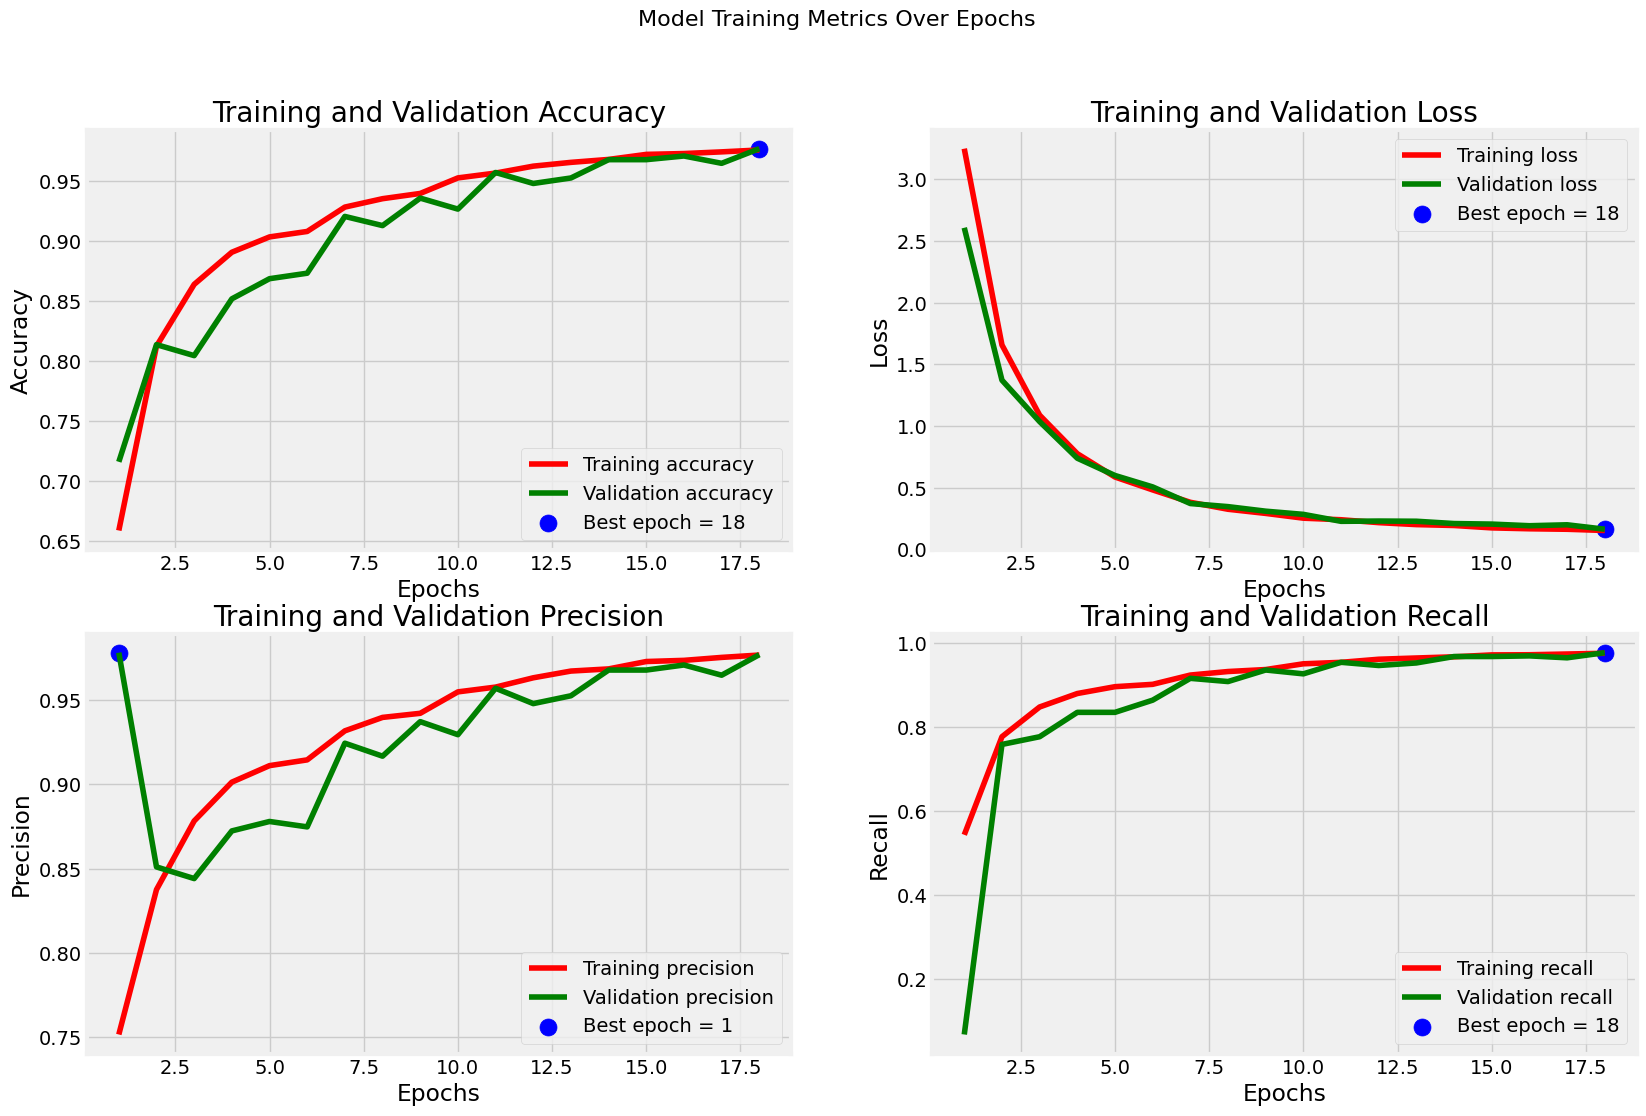

In [16]:
#Visualize the training metrics of each epoch

# Get training and validation metrics from history
metrics = ['accuracy', 'loss', 'precision', 'recall']
train_metrics = {m: history.history[m] for m in metrics}
validation_metrics = {m: history.history[f'val_{m}'] for m in metrics}

# Find best epochs and values
# Find lowest loss in our training history/when it made the least amt of mistakes
best_epochs = {}
best_values = {}
for m in metrics:
  if m == 'loss':
    idx = np.argmin(validation_metrics[m])
  else:
    idx = np.argmax(validation_metrics[m])
  best_epochs[m] = idx + 1
  best_values[m] = validation_metrics[m][idx]

# Plot metrics
plt.figure(figsize=(20,12))
plt.style.use('fivethirtyeight')

# Create 4 plots
# Model Accuracy over time, Model Loss over time, Model Precision, Model Recall
for i, metric in enumerate(metrics, 1):
  plt.subplot(2,2,i)
  epochs = range(1, len(train_metrics[metric]) + 1)

  plt.plot(epochs, train_metrics[metric], 'r', label=f'Training {metric}')
  plt.plot(epochs, validation_metrics[metric], 'g', label=f'Validation {metric}')
  plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue', label=f'Best epoch = {best_epochs[metric]}')
  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [17]:
train_score = cnn_model.evaluate(train_gen, verbose=1) # How well model learned patterns, etc.
validation_score = cnn_model.evaluate(valid_gen, verbose=1) # If training process was effective
test_score = cnn_model.evaluate(test_gen, verbose=1) # How model will perform realistically in production

print(f'Train Accuracy: {train_score[1]*100:.2f}%')
print(f'Train Loss: {train_score[0]:.4f}')
print(f"\n\nValidation Accuracy: {validation_score[1]*100:.2f}%")
print(f'Validation Loss: {validation_score[0]:.4f}')
print(f"\n\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f'Test Loss: {test_score[0]:.4f}')

357/357 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.9967 - loss: 0.1132 - precision: 0.9967 - recall: 0.9966
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.9705 - loss: 0.1845 - precision: 0.9705 - recall: 0.9705
 2/41 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9844 - loss: 0.1685 - precision: 0.9844 - recall: 0.9844 

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.9811 - loss: 0.1713 - precision: 0.9811 - recall: 0.9811
Train Accuracy: 99.58%
Train Loss: 0.1138


Validation Accuracy: 97.71%
Validation Loss: 0.1674


Test Accuracy: 98.32%
Test Loss: 0.1754


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step


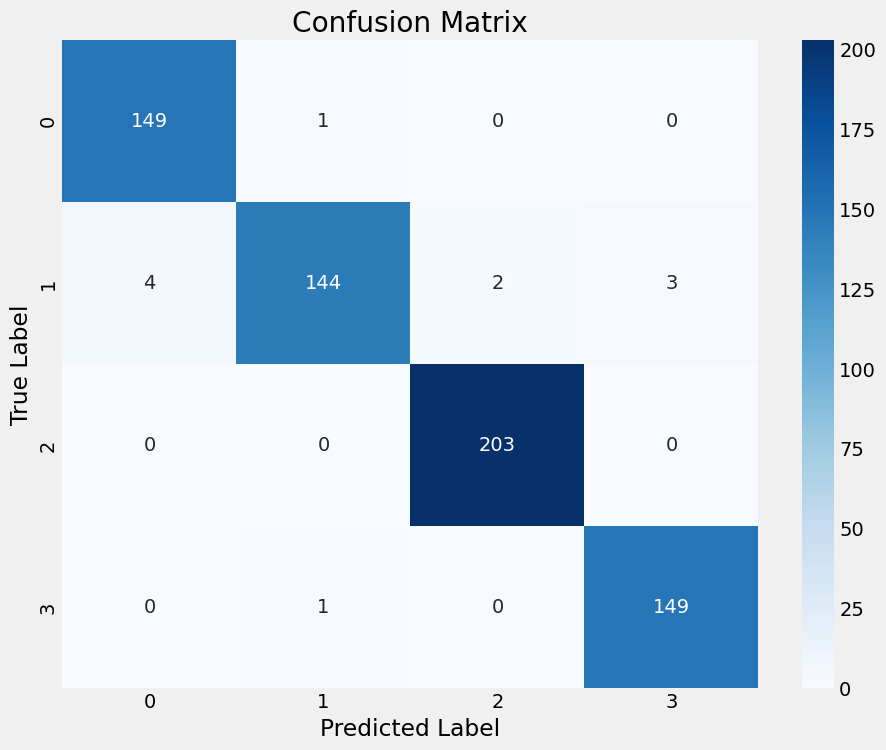

In [18]:
# Visualize how well the model does for each class
preds = cnn_model.predict(test_gen) # asking model to make predictions on the mri scans in testing dataset
# output probabilities are how confident the model is that the mri fits into each class
y_pred = np.argmax(preds, axis=1) # convert probability into actual predictions
# picks class the model is most confident about

# map class names to numerical indices
class_dict = {
    0: 'glinoma',
    1: 'meningioma',
    2: 'no_tumor',
    3: 'pituitary'
}

#Then create and display the confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label") #what model thought the mri was
plt.ylabel("True Label") # what it actually was
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Print classification report
# takes in the true classes for the images vs the predicted classes
clr = classification_report(test_gen.classes, y_pred)
print(clr)

#NOTE:
# EX. for precision, the model is incorrectly identifying
# other tumors as being "no tumor"
# for recall, it is accurately identifying almost all "no tumor" cases
# this could be a problem in the medical field since tumors would take
# longer to be diagnosed

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       150
           1       0.99      0.94      0.96       153
           2       0.99      1.00      1.00       203
           3       0.98      0.99      0.99       150

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



In [20]:
cnn_model.save('/kaggle/working/cnn_model.h5')